<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/Hecathon/Covid_resnet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from pathlib import Path
import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

In [39]:
 model1 = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
 import torchvision.models as models
 model = models.resnet34(pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [5]:
num_classes=3
model1.classifier=nn.Linear(1280,num_classes,bias=True)

In [41]:
model.Linear=nn.Linear(512,num_classes,bias=True)

In [9]:
!7z x '/content/gdrive/My Drive/Colab Notebooks/covid.7z' -o'/content/data/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/Colab Notebooks/                                                   1 file, 1244200369 bytes (1187 MiB)

Extracting archive: /content/gdrive/My Drive/Colab Notebooks/covid.7z
--
Path = /content/gdrive/My Drive/Colab Notebooks/covid.7z
Type = 7z
Physical Size = 1244200369
Headers Size = 25838
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 4        0% 25 - covid/COVID-19/COVID-19 (118).png                                             1% 51 - covid/COVID-19/COVID-19 (21).png    

In [10]:
label=[]
label_c=[]
dataset=[]
dataset_c=[]
import numpy as np
from PIL import Image

# Getting the BG list and replicate each background to 4000 


for root_covid, dirs_covid, files_covid in os.walk("/content/data/covid/COVID-19/"):
   for name_covid in files_covid:
         p= Image.open(root_covid +'/'+ name_covid)
         dataset.append(root_covid +'/'+ name_covid)
         label.append(0)

for root_n, dirs_n, files_n in os.walk("/content/data/covid/NORMAL/"):
   for name_n in files_n:
         p= Image.open(root_n +'/'+ name_n)
         dataset.append(root_n +'/'+ name_n)
         label.append(1)

for root_p, dirs_p, files_p in os.walk("/content/data/covid/Viral Pneumonia/"):
   for name_p in files_p:
         p= Image.open(root_p +'/'+ name_p)
         dataset.append(root_p +'/'+ name_p)
         label.append(2)
     

In [16]:
tot_xray={}
tot_xray={'xray' : dataset , 'labels' : label}

In [11]:
c_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       #transforms.RandomRotation((-15,15),fill=(0)),
                                       #transforms.Grayscale(),
                                       transforms.ToTensor(),
                                      
                                       #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
n_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor()
                                      
      
                                       ])


In [12]:
import glob
from PIL import Image
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [17]:
length=len(tot_xray['xray'])

In [18]:
length

3562

In [19]:
class Myclass(torch.utils.data.Dataset):
    def __init__ (self,tot_xray,total,transform=None):
       #super(depthmask, self).__init__()
       self.tot_xray = tot_xray
       self.total=total
       self.transform = transform
       

    def __getitem__ (self, idx): 
      
         xray = Image.open(self.tot_xray['xray'][idx]).convert('RGB')

         final_xray = self.transform[0](xray)
         sample = {'total_xray' : final_xray , 'labels' : self.tot_xray['labels'][idx] }
         #final_xray = self.transform[1](xray_n)
         #sample = {'total_xray' : final_xray , 'labels' : self.tot_xray['labels'][idx] }
         #final_xray = self.transform[1](xray_p)
         #sample = {'total_xray' : final_xray , 'labels' : self.tot_xray['labels'][idx] }
         return sample
    
    def __len__ (self):
       return (self.total)

In [20]:
final_dataset=Myclass(tot_xray,length,transform=[c_transform,n_transform])
for i in range(len(final_dataset)):
    sample = final_dataset[i]
    print(i,'-xray:', sample['total_xray'].size())

    if i == 3:
        break

0 -xray: torch.Size([3, 224, 224])
1 -xray: torch.Size([3, 224, 224])
2 -xray: torch.Size([3, 224, 224])
3 -xray: torch.Size([3, 224, 224])


0


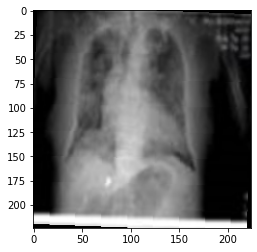

In [21]:
import numpy as np
plt.imshow((np.transpose((sample['total_xray'].cpu().detach().numpy()),(1,2,0))))
print((sample['labels']))


In [22]:
print(len(final_dataset))

3562


In [23]:
SEED = 1
torch.cuda.empty_cache()
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED) 
train_dataset, valid_dataset = torch.utils.data.random_split(final_dataset, (3200, 362))  

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32,
                                         shuffle=False, num_workers=2)

CUDA Available? True


In [46]:
from tqdm import tqdm
loss_1=[]
loss_2=[]
train_losses = []
test_losses = []
train_acc = []
test_acc = []
pred_1=[]
lab_1=[]
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  cri = nn.CrossEntropyLoss()
  #cri=nn.MSELoss()
  for batch_idx, data in enumerate(pbar):
    # get samples
    data['total_xray'] = data['total_xray'].to(device)
    data['labels'] = data['labels'].to(device)


    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data['total_xray'])
    #y_pred = model(data['fgbg'])
   
    # Calculate loss

    loss=cri(y_pred,data['labels'])
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(data['labels'].view_as(pred)).sum().item()
    processed += len(data['total_xray'])
    
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    map=[]
    test_loss = 0
    correct = 0
    cri =  nn.CrossEntropyLoss()
    with torch.no_grad():
        for data in test_loader:
            data['total_xray'] = data['total_xray'].to(device)
            data['labels'] = data['labels'].to(device)

            output= model(data['total_xray'])
            
            loss=cri(output,data['labels'])
          
            test_loss += loss.item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(data['labels'].view_as(pred)).sum().item()
            pred_1.append(pred)
            lab_1.append(data['labels'])
    
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    
  

In [43]:
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
#tqdm._instances.clear()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.90,weight_decay=0.001)
#optimizer=optim.Adam(model1.parameters(), lr=0.055, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
scheduler=StepLR(optimizer,step_size=9,gamma=0.1)


EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model.to('cuda'), device, trainloader, optimizer, epoch)
    test(model, device, testloader)
    scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1263255774974823 Batch_id=99 Accuracy=89.09: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]
  0%|          | 0/100 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 340/362 (93.92%)

EPOCH: 1


Loss=0.0061579435132443905 Batch_id=99 Accuracy=96.78: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]
  0%|          | 0/100 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 354/362 (97.79%)

EPOCH: 2


Loss=0.006367661990225315 Batch_id=99 Accuracy=97.47: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]
  0%|          | 0/100 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 358/362 (98.90%)

EPOCH: 3


Loss=0.008701655082404613 Batch_id=99 Accuracy=98.69: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]
  0%|          | 0/100 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 358/362 (98.90%)

EPOCH: 4


Loss=0.005416581407189369 Batch_id=99 Accuracy=98.91: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]
  0%|          | 0/100 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 350/362 (96.69%)

EPOCH: 5


Loss=0.0006957398145459592 Batch_id=99 Accuracy=99.31: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]
  0%|          | 0/100 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 360/362 (99.45%)

EPOCH: 6


Loss=0.011673166416585445 Batch_id=99 Accuracy=99.75: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]
  0%|          | 0/100 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 361/362 (99.72%)

EPOCH: 7


Loss=0.0046773748472332954 Batch_id=99 Accuracy=99.75: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]
  0%|          | 0/100 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 361/362 (99.72%)

EPOCH: 8


Loss=9.493375546298921e-05 Batch_id=99 Accuracy=99.75: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]
  0%|          | 0/100 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 358/362 (98.90%)

EPOCH: 9


Loss=0.0017842939123511314 Batch_id=99 Accuracy=99.91: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]



Test set: Average loss: 0.0006, Accuracy: 361/362 (99.72%)



In [47]:
test(model, device, testloader)


Test set: Average loss: 0.0006, Accuracy: 361/362 (99.72%)



In [48]:
len(pred_1)

12

In [49]:
pred2=[]
lab2=[]
for i in range(11):
 pred2 += pred_1[i].squeeze().tolist()

for i in range(11):
 lab2 += lab_1[i].squeeze().tolist()

In [50]:
print(confusion_matrix(pred2, lab2))

[[ 90   0   0]
 [  0 125   0]
 [  0   0 137]]
